In [65]:
import tools
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols
from scipy.optimize import fsolve
import seaborn as sns
import numpy as np
from lmfit import Parameters, fit_report, minimize
#import emcee
!jupyter nbconvert --to script outage_bunching.ipynb 
# converts notebook to py file needed to import results from bunching
from outage_bunching import bunching, z_lower60, z_lower120, missing60, missing120
#import outage_bunching

np.random.seed(111)

[NbConvertApp] Converting notebook outage_bunching.ipynb to script
[NbConvertApp] Writing 12630 bytes to outage_bunching.py


In [8]:
wd = Path.cwd()
data = pd.read_csv(wd.parent/'data'/'data_transformed'/'outage_bunch.csv')

#data.head()

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


$\pi$: revenue loss from outage

Calculation: \
$r =$ unserved kWh / duration of outage \
$\pi = r * tariff$

unserved kWh is a function of the number of customers affected and the duration of the outage

median pi: 44.44444444444444
0.8333333333333334 1.6666666666666667


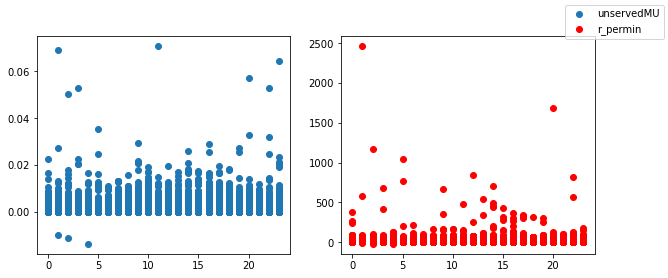

In [9]:
## calculate pi 

#the tariff is a price per kwh
tariff = 8

data['r_permin'] = data.apply(lambda row: row.unservedmuduetooutage * 1e6 / row.duration_minutes, axis = 1)

data['pi'] = data.r_permin * tariff

pi = data.pi.median()

print('median pi:', pi)



# define parameters 
phi = 50/60 
phi120 = 100/60
print(phi, phi120)

#sns.kdeplot(data.r_permin)

# 
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(data.hour_of_day, data.unservedmuduetooutage, label = 'unservedMU')
ax[1].scatter(data.hour_of_day, data.r_permin, label='r_permin', color='red')
fig.legend()

#data.r_permin.describe()

## model estimation : alpha

non-linear least squares; focus on bunching around 60

$ (\frac{\pi + \phi}{\pi}) (\frac{x}{x + \Delta x}) = \frac{1}{\alpha} [(\frac{\pi + \phi}{\phi})^{\alpha / 1+\alpha} (1+\alpha) - (1 + \frac{\Delta x}{x})^{\alpha}]$

In [67]:
# code source: https://lmfit.github.io/lmfit-py/fitting.html

# parameters to be estimated
pars = Parameters()
pars.add('alpha', value = .8)

def residual(pars,pi, data, dx ,phi = phi, x = 60):
        vals = pars.valuesdict()
        alpha = vals['alpha']
        # RHS of equation
        model = 1/alpha * (((pi + phi)/phi)**(alpha /(1+alpha)) * (1+alpha) - (1 + (dx/x))**alpha )
        return model - data

alphas = {}
# for each firm separately
for f in bunching:
    if f in data.discom.unique():
        dt = data[data.discom == f]
    else: dt = data.copy()
    # keep only non-negative values
    dt = dt[dt.pi > 0]
    # restrict region of x using counterfactual duration
    #dt = dt[(dt.duration_cf >= 40 ) & (dt.duration_cf <= 110)]
    dx60 = bunching[f]['bunch60'].total_bunch()    

    # calculate left side of equation
    left = dt.apply(lambda row: (row.pi + phi) / row.pi * 60/(60+dx60) , axis = 1).to_numpy()
    fit_params = Parameters()
    # first guess of alpha
    fit_params.add('alpha', value = 0.5)
    # fit model by minimizing RHS - LHS
    out = minimize(residual, fit_params, args = (dt.pi.to_numpy(),), kws={'data': left, 'dx':dx60})
    #print(fit_report(out)) # output
    alphas[f] = {'output': out,'value': out.params['alpha'].value, 'std':out.params['alpha'].stderr}

#print(alphas)

In [61]:
for f in bunching:
    out = alphas[f]['output']
    print(f'---------{f}----------------------')
    print('Parameter    Value       Stderr')
    for name, param in out.params.items():
        print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')


---------brpl----------------------
Parameter    Value       Stderr
alpha      -0.84177     0.00204
---------bypl----------------------
Parameter    Value       Stderr
alpha      -0.97402     0.00023
---------tata----------------------
Parameter    Value       Stderr
alpha      -0.96339     0.00159
---------pooled----------------------
Parameter    Value       Stderr
alpha      -0.94023     0.00098


In [62]:
# create new column alpha and assign values
data['alpha'] = 0
for f in alphas:
    alpha = alphas[f]['value']
    if f in data.discom.unique():
        column = 'alpha'        
        data.loc[data.discom == f, column] = alpha
    else:
        column = f'alpha_{f}'
        data[column] = alpha    
    

## plot of cost function 
$C(x,\sigma) = \frac{\sigma}{\alpha} (\frac{x}{\sigma})^{-\alpha}$

Text(0.5, 1.0, 'sigma: 10, alpha: -0.94')

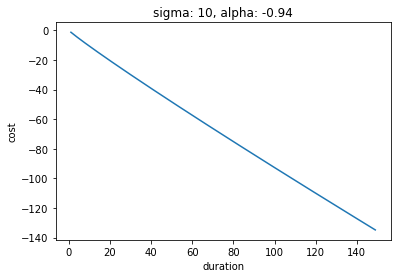

In [63]:
# fix sigma
sigma = 10
# set alpha
alpha = alphas['pooled']['value']

x = np.arange(1,150)

costs = [tools.C(z, sigma, alpha) for z in x]

fig, ax = plt.subplots()
ax.plot(x,costs)
ax.set_xlabel('duration')
ax.set_ylabel('cost')
ax.set_title(f'sigma: {sigma}, alpha: {np.round(alpha,2)}')


## calculate the $\sigma$'s based on the counterfactual x's and alpha's

- $x^* = \sigma (\pi +\phi N)^{-1/(1+\alpha)}$
- for each observation (duration)
- minimize the difference between the theoretical optimal duration $x^*$ given our parameters and the counterfactual duration
- the optimal $\sigma$ is the minimizer of the difference

In [64]:
data['sigma'] = 0

def get_sigma(s,x, N, pi, alpha):
    if x < 60:
        exp = tools.xopt(s, pi, phi=0, alpha = alpha, N=N) - x
    elif x < 120:
        exp = tools.xopt(s, pi, phi=50/60, alpha = alpha, N=N) - x
    else:   
        exp = tools.xopt(s, pi, phi=100/60, alpha = alpha, N=N) - x
    return exp

for i in data.index:
    s = symbols('s')
    x = data.loc[i, 'duration_cf']
    N = data.loc[i, 'noofcustomersaffected']
    pi = data.loc[i, 'pi']
    alp = data.loc[i,'alpha']
    data.loc[i,'sigma'] = fsolve(get_sigma, x0 = 10, args = (x, N, pi, alp))[0]


C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

count    9.123000e+04
mean     1.288230e+06
std      2.587004e+07
min      7.388960e-22
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      1.014594e+09
Name: sigma, dtype: float64

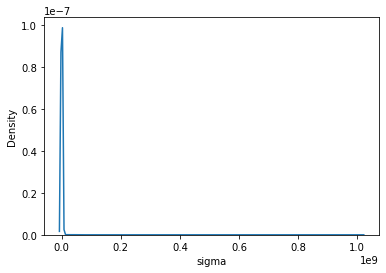

In [ ]:
sns.kdeplot(x = data.sigma)
#plt.xlim(-1000,20000)
data.sigma.describe()


In [ ]:
# export 
data.to_csv(wd.parent/'data'/'data_transformed'/'outage_bunch_est.csv', index=False)

# Alternative calculation of alpha



solve for $\alpha$ and compare: $K(x^I) = K(x^*)$

$K(x^I) = (\pi + \phi)^{\alpha /1+\alpha} (x^* + \Delta x^*) \pi^{1/1+\alpha}  (1 + 1/\alpha)$


at $x$ around $60$: $\phi = 50$

If $x>120$: $\phi = 100$


I am now doing it for N=1, not sure if that's right. Also, we should double check the functions. What values of $\pi$ and $\phi$ should we use? For $\pi$ we could maybe do a weighted average

alpha: 5.925371436624084 deltax 4.303755439887405
alpha: 5.283274454191148 deltax 1.0355002865033742


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  first = sigma / alpha
<ipython-input-28-9f8946c7dab8>:25: RuntimeWarning: invalid value encountered in double_scalars
  return L(a) - R(a)


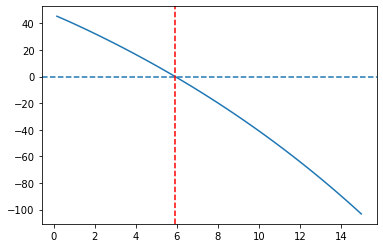

In [ ]:
alpha60 = tools.solve_alpha(60, bunch60.total_bunch(), pi, phi=50/60, phi120 = 100/60, startingvalue = 10)
alpha120 = tools.solve_alpha(120, bunch120.total_bunch(), pi, phi=50/60, phi120 = 100/60, startingvalue=10)

print('alpha:',alpha60, 'deltax', bunch60.total_bunch())
print('alpha:',alpha120, 'deltax', bunch120.total_bunch())

alpha = alpha60
#alpha = 0.8

# plot indifference as a function of alpha
delta_x = bunch60.total_bunch()
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+50/60)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=50/60, phi120 = 100/60,alpha=a, N=1)
    
def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)

alphas = np.linspace(0,15, 100)
sol =  [solution(a) for a in alphas]
plt.plot(alphas,sol)
plt.axhline(0, linestyle = 'dashed')
plt.axvline(alpha60, linestyle='dashed', color = 'red')